# ANN for Options Pricing

1. Data Preprocessing
2. Defining ANN Architecture
3. Choosing activation function

# 1. Data Preprocessing

Some variables must be dropped, others must be repurposed. 

All columns are scaled using standardisation sklearn standard scaler, categorical variables are one hot encoded


In [146]:
import pandas as pd
import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt

In [ ]:
df1 = pd.read_csv('data/SPX/UnderlyingOptionsIntervals_3600sec_calcs_oi_2024-07-26.csv')
df2 = pd.read_csv('data/SPX/UnderlyingOptionsIntervals_3600sec_calcs_oi_2024-08-30.csv')
df3 = pd.read_csv('data/SPX/UnderlyingOptionsIntervals_3600sec_calcs_oi_2024-09-27.csv')

In [148]:
# Concatenating data to form a combined dataframe for put options
df_call = pd.concat([
    df1[(df1['option_type'] == 'C') & (df1['root'] == 'SPX')],
    df2[(df2['option_type'] == 'C') & (df2['root'] == 'SPX')],
    df3[(df3['option_type'] == 'C') & (df3['root'] == 'SPX')]
], ignore_index=True)

print("Null Values:")
print(df_call.isnull().sum())

Null Values:
underlying_symbol           0
quote_datetime              0
root                        0
expiration                  0
strike                      0
option_type                 0
open                        0
high                        0
low                         0
close                       0
trade_volume                0
bid_size                    0
bid                         0
ask_size                    0
ask                         0
underlying_bid              0
underlying_ask              0
implied_underlying_price    0
active_underlying_price     0
implied_volatility          0
delta                       0
gamma                       0
theta                       0
vega                        0
rho                         0
open_interest               0
dtype: int64


In [149]:
df_put = pd.concat([
    df1[(df1['option_type'] == 'P') & (df1['root'] == 'SPX')],
    df2[(df2['option_type'] == 'P') & (df2['root'] == 'SPX')],
    df3[(df3['option_type'] == 'P') & (df3['root'] == 'SPX')]
], ignore_index=True)

print("Null Values:")
print(df_put.isnull().sum())

Null Values:
underlying_symbol           0
quote_datetime              0
root                        0
expiration                  0
strike                      0
option_type                 0
open                        0
high                        0
low                         0
close                       0
trade_volume                0
bid_size                    0
bid                         0
ask_size                    0
ask                         0
underlying_bid              0
underlying_ask              0
implied_underlying_price    0
active_underlying_price     0
implied_volatility          0
delta                       0
gamma                       0
theta                       0
vega                        0
rho                         0
open_interest               0
dtype: int64


In [150]:
df_put.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82943 entries, 0 to 82942
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   underlying_symbol         82943 non-null  object 
 1   quote_datetime            82943 non-null  object 
 2   root                      82943 non-null  object 
 3   expiration                82943 non-null  object 
 4   strike                    82943 non-null  float64
 5   option_type               82943 non-null  object 
 6   open                      82943 non-null  float64
 7   high                      82943 non-null  float64
 8   low                       82943 non-null  float64
 9   close                     82943 non-null  float64
 10  trade_volume              82943 non-null  int64  
 11  bid_size                  82943 non-null  int64  
 12  bid                       82943 non-null  float64
 13  ask_size                  82943 non-null  int64  
 14  ask   

In [151]:
# New column time_to_expiration

df_call['expiration'] = pd.to_datetime(df_call['expiration'])
df_call['quote_datetime'] = pd.to_datetime(df_call['quote_datetime'])

# Calculate time-to-expiration as the difference in days
df_call['time_to_expiration'] = (df_call['expiration'] - df_call['quote_datetime']).dt.days

# Repeat for df_put if needed
df_put['expiration'] = pd.to_datetime(df_put['expiration'])
df_put['quote_datetime'] = pd.to_datetime(df_put['quote_datetime'])
df_put['time_to_expiration'] = (df_put['expiration'] - df_put['quote_datetime']).dt.days

In [152]:
# New column bid_ask_spread
df_call['bid_ask_spread'] = df_call['underlying_ask'] - df_call['underlying_bid']
df_put['bid_ask_spread'] = df_put['underlying_ask'] - df_put['underlying_bid']

In [153]:
# Dropping irrelevant columns
# root, underlying_symbol, implied_underlying_price, quote_datetime, expiration, bid_size, ask_size, underlying_bid, underlying_ask, open, high, low
columns_to_drop = ['root', 'underlying_symbol', 'implied_underlying_price', 'quote_datetime', 
                   'expiration', 'open', 'high', 'low', 'bid_size', 'ask_size', 
                   'underlying_bid', 'underlying_ask']

df_call = df_call.drop(columns=columns_to_drop, axis=1)
df_put = df_put.drop(columns=columns_to_drop, axis=1)


In [154]:
# Drop rows where the 'close' column has a value of 0
df_call = df_call[df_call['close'] != 0]

# Verify the changes
print(f"Remaining rows after dropping: {len(df_call)}")


Remaining rows after dropping: 4542


In [155]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Step 1: Fit a scaler to the original 'close' column
target_scaler = StandardScaler()
target_scaler.fit(df_call[['close']])

# Separating the numerical columns for scaling
numerical_columns = ['strike', 'trade_volume', 'active_underlying_price', 
                     'implied_volatility', 'delta', 'gamma', 'theta', 
                     'vega', 'rho', 'open_interest', 'time_to_expiration', 'bid_ask_spread']

# Initialize the StandardScaler for features
scaler = StandardScaler()

# Scale the numerical columns
df_call[numerical_columns] = scaler.fit_transform(df_call[numerical_columns])

# Optionally, encode the categorical 'option_type'
encoder = OneHotEncoder(sparse_output=False)
encoded_option_type = encoder.fit_transform(df_call[['option_type']])

# Convert the encoded categorical feature to a DataFrame and merge it back
encoded_df = pd.DataFrame(encoded_option_type, columns=encoder.get_feature_names_out(['option_type']))
df_call = df_call.drop(['option_type'], axis=1)  # Drop the original 'option_type' column
df_call = pd.concat([df_call.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)


In [138]:
# Scaling for df_put

# Separating the numerical columns for scaling
numerical_columns = ['strike', 'close', 'trade_volume', 'active_underlying_price', 
                     'implied_volatility', 'delta', 'gamma', 'theta', 
                     'vega', 'rho', 'open_interest', 'time_to_expiration', 'bid_ask_spread']

# Initialize the StandardScaler
scaler = StandardScaler()

# Scale the numerical columns
df_put[numerical_columns] = scaler.fit_transform(df_put[numerical_columns])

# Optionally, encode the categorical 'option_type' if needed
# Example using OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)  # Updated argument name
encoded_option_type = encoder.fit_transform(df_put[['option_type']])

# Convert the encoded categorical feature to a DataFrame and merge it back
encoded_df = pd.DataFrame(encoded_option_type, columns=encoder.get_feature_names_out(['option_type']))
df_put = df_put.drop(['option_type'], axis=1)  # Drop the original 'option_type' column
df_put = pd.concat([df_put.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

# 2. Defining the ANN Architecture

1. Input Layer
    - 15 neurons (one for each input feature)
2. Hidden Layer
    - 2 hidden layers
        - First Layer (30 neurons)
        - Second Layer (15 neurons)
3. Output Layer
    - 1 neuron: the predicted price

In [156]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU


In [157]:
# Define the model
model = Sequential()

# Input layer and first hidden layer with Leaky ReLU activation
# Specify alpha for Leaky ReLU (default is usually 0.01)
model.add(Dense(units=30, input_shape=(15,)))  # 30 neurons in the first hidden layer
model.add(LeakyReLU(alpha=0.01))

# Second hidden layer with Leaky ReLU activation
model.add(Dense(units=15))  # 15 neurons in the second hidden layer
model.add(LeakyReLU(alpha=0.01))

# Output layer with 1 neuron to predict the option price (no activation function for regression)
model.add(Dense(units=1))

# Compile the model with a suitable optimizer and loss function for regression
model.compile(optimizer='adam', loss='mse')

# Summary of the model architecture
model.summary()

/Users/joelsng/Library/Python/3.12/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/joelsng/Library/Python/3.12/lib/python/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_41 (Dense)                │ (None, 30)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_28 (LeakyReLU)      │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 15)             │           465 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_29 (LeakyReLU)      │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 961 (3.75 KB)

 Trainable params: 961 (3.75 KB)

 Non-trainable params: 0 (0.00 B)

In [158]:
from sklearn.model_selection import train_test_split

X = df_call.drop(columns=['close'])  # Assuming 'close' is the target column you want to predict
y = df_call['close']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the datasets to numpy arrays for compatibility with TensorFlow/Keras
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")


Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - loss: 80397.7422 - val_loss: 723.2510
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 25428.5742 - val_loss: 676.9440
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 12056.9893 - val_loss: 673.0979
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 12151.4531 - val_loss: 670.0768
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - loss: 37564.3242 - val_loss: 666.6688
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - loss: 6925.9038 - val_loss: 664.7128
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 3964.6404 - val_loss: 657.6146
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 20799.7363 - val_loss: 636.8292
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 11186.8672 - val_loss: 615.2836
Epoch 10/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 17594.7363 - val_loss: 613.8530
Epoch 11/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - loss: 6128.9629 - val_loss

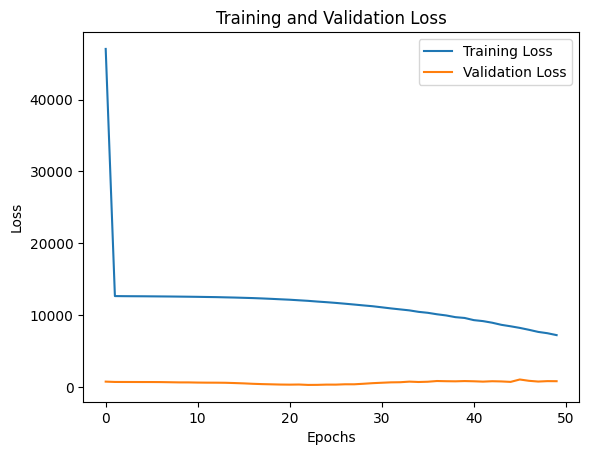

In [159]:
# Visualize training loss and validation loss over epochs
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [160]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
Mean Squared Error: 1462.7846229316972
Mean Absolute Error: 7.792713731258485
Root Mean Squared Error: 38.246367447532805
R-squared: 0.9906341713809085


In [161]:
# Step 6: Unscale the predictions and actual target values
y_pred_unscaled = target_scaler.inverse_transform(y_pred)  # Inverse transform predictions
y_test_unscaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))  # Inverse transform actual values

# Step 7: Calculate evaluation metrics on unscaled values
mse_unscaled = mean_squared_error(y_test_unscaled, y_pred_unscaled)
mae_unscaled = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
rmse_unscaled = np.sqrt(mse_unscaled)
r2_unscaled = r2_score(y_test_unscaled, y_pred_unscaled)

print(f"Unscaled Mean Squared Error: {mse_unscaled}")
print(f"Unscaled Mean Absolute Error: {mae_unscaled}")
print(f"Unscaled Root Mean Squared Error: {rmse_unscaled}")
print(f"Unscaled R-squared: {r2_unscaled}")

Unscaled Mean Squared Error: 221182656.24703324
Unscaled Mean Absolute Error: 3030.2190442523083
Unscaled Root Mean Squared Error: 14872.21087286733
Unscaled R-squared: 0.9906341718993888


# Finetuning Hyperparameters

Hyperparameters to learn
1. Number of hidden layers
2. Number of neurons in each layer
3. Learning rate
4. Batch size
5. Activation Functions
6. Dropout rate

In [73]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout
from scikeras.wrappers import KerasRegressor

def build_model(optimizer='adam', learning_rate=0.001, num_neurons=30, num_layers=1, dropout_rate=0.0):
    model = Sequential()
    model.add(Dense(units=num_neurons, input_shape=(15,)))  # Input layer + First hidden layer
    model.add(LeakyReLU(alpha=0.01))

    # Adding more hidden layers based on num_layers parameter
    for _ in range(num_layers - 1):
        model.add(Dense(units=num_neurons))
        model.add(LeakyReLU(alpha=0.01))
        if dropout_rate > 0:
            model.add(Dropout(rate=dropout_rate))  # Add dropout if dropout_rate is provided

    # Output layer
    model.add(Dense(units=1))

    # Compile the model with the specified optimizer and learning rate
    opt = optimizer if isinstance(optimizer, str) else optimizer(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='mse', metrics=['mse'])
    return model



In [74]:
from scikeras.wrappers import KerasRegressor

keras_model = KerasRegressor(
    build_fn=build_model,
    optimizer='adam',
    learning_rate=0.001,
    num_neurons=30,
    num_layers=1,
    dropout_rate=0.0,
    epochs=100,
    batch_size=32,
    verbose=0
)


In [75]:
param_grid = {
    'num_neurons': [20, 30, 50],  # Number of neurons in each layer
    'num_layers': [1, 2, 3],  # Number of hidden layers
    'learning_rate': [0.001, 0.01, 0.1],  # Learning rates to try
    'optimizer': ['adam', 'rmsprop'],  # Different optimizers to try
    'batch_size': [32, 64, 128],  # Different batch sizes
    'dropout_rate': [0.0, 0.2, 0.3, 0.5],  # Dropout rate to prevent overfitting
    'epochs': [50, 100]  # Number of epochs
}


In [ ]:
random_search = RandomizedSearchCV(
    estimator=keras_model,
    param_distributions=param_grid,
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Fit random search
random_search.fit(X_train, y_train)

# Print the best parameters and best score
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")


In [ ]:
from tensorflow.keras.optimizers import Adam

# Define the model
model = Sequential()

# Input layer and first hidden layer with Leaky ReLU activation
# Specify alpha for Leaky ReLU (default is usually 0.01)
model.add(Dense(units=20, input_shape=(15,)))  # 20 neurons in the first hidden layer (as per best parameters)
model.add(LeakyReLU(alpha=0.01))
model.add(Dropout(0.2))  # Add dropout with a rate of 0.2

# Second hidden layer with Leaky ReLU activation
model.add(Dense(units=20))  # 20 neurons in the second hidden layer (as per best parameters)
model.add(LeakyReLU(alpha=0.01))
model.add(Dropout(0.2))  # Add dropout with a rate of 0.2

# Output layer with 1 neuron to predict the option price (no activation function for regression)
model.add(Dense(units=1))

# Create an Adam optimizer with the best-found learning rate
optimizer = Adam(learning_rate=0.001)  # Setting learning rate as per best parameters

# Compile the model with the specified optimizer and loss function
model.compile(optimizer=optimizer, loss='mse')

# Summary of the model architecture
model.summary()


In [ ]:
from sklearn.model_selection import train_test_split

X = df_call.drop(columns=['close'])  # Assuming 'close' is the target column you want to predict
y = df_call['close']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the datasets to numpy arrays for compatibility with TensorFlow/Keras
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")


In [ ]:
from sklearn.preprocessing import StandardScaler

# Assuming you scaled your target variable 'close' during preprocessing

# Step 1: Fit the scaler on the original 'close' column
target_scaler = StandardScaler()
target_scaler.fit(df_call[['close']])

# Step 2: Inverse transform the predictions and the actual test values
y_pred_unscaled = target_scaler.inverse_transform(y_pred)
y_test_unscaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# Step 3: Calculate evaluation metrics on unscaled values
mse_unscaled = mean_squared_error(y_test_unscaled, y_pred_unscaled)
mae_unscaled = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
rmse_unscaled = np.sqrt(mse_unscaled)
r2_unscaled = r2_score(y_test_unscaled, y_pred_unscaled)

print(f"Unscaled Mean Squared Error: {mse_unscaled}")
print(f"Unscaled Mean Absolute Error: {mae_unscaled}")
print(f"Unscaled Root Mean Squared Error: {rmse_unscaled}")
print(f"Unscaled R-squared: {r2_unscaled}")
